In [1]:
import sys
sys.path.append('../')

import numpy as np
import torch
import msBO
from msBO import plot_msGP_over_states

In [2]:
n_control = 2
n_obj = 4
n_state_PV = 2
n_state = 3

control_CSETs = [f'PSC{i}:I_CSET' for i in range(n_control)]
control_RDs = [f'PSC{i}:I_RD' for i in range(n_control)]
control_tols = [0.1]*len(control_CSETs)
control_min  = [0.0]*len(control_CSETs)
control_max  = [1.0]*len(control_CSETs)
state_CSETs  = [f'SLIT{i}:POS_CSET' for i in range(n_state_PV)]
state_RDs  = [f'SLIT{i}:POS_RD' for i in range(n_state_PV)]
state_tols   = [0.1]*len(state_CSETs)
state_vals   = [[i]*n_state_PV for i in range(n_state)]
state_names  = None
objective_PVs= [f'BPM{i}:XPOS_RD' for i in range(n_obj)]
monitor_PVs  = []

In [3]:
vm = msBO.virtual_machineIO.VM( 
    control_CSETs = control_CSETs + state_CSETs,
    control_RDs = control_RDs + state_RDs,
    monitor_PVs= objective_PVs + monitor_PVs,
    control_min= control_min + [0]*n_state_PV,
    control_max= control_max + [n_state-1]*n_state_PV,
)

machineIO = msBO.construct_machineIO.construct_machineIO(
    virtual_machineIO=vm, 
    set_manually=False)

In [4]:
# av,df = machineIO.fetch_data(objective_PVs)
# df

In [5]:
class objective_constructor:
    def __init__(self, n_obj=None, y_tol=None):
        if not isinstance(y_tol,torch.Tensor):
            self.y_tol = torch.tensor(y_tol)
        else:
            self.y_tol = y_tol

    def __call__(self, y):
        # Define shape_padding based on the dimensions of y, with '1's for broadcasting
        shape_padding = tuple(1 for _ in range(y.ndim - 1))  # y must be shape of (*, n_state, n_obj)
        obj = torch.mean(torch.std(y / self.y_tol.view(*shape_padding, -1), dim=-2), dim=-1)
        return obj

multi_state_objective_fn = objective_constructor(y_tol = [1]*n_obj)

In [6]:
msbo = msBO.MultiStateBO(
    machineIO,
    multi_state_objective_fn = multi_state_objective_fn,
    objective_PVs = objective_PVs,
    control_CSETs = control_CSETs,
    control_RDs   = control_RDs,
    control_tols  = control_tols,
    control_min   = control_min,
    control_max   = control_max,
    state_CSETs   = state_CSETs,
    state_RDs     = state_RDs,
    state_tols    = state_tols,
    state_vals    = state_vals,
    state_names   = state_names,
    monitor_PVs   = monitor_PVs,
    local_optimization = False,
    local_bound_size   = None
)

In [7]:
msbo.init(8)

In [8]:
msbo.optimize_global(neval=3, beta=16)

In [9]:
msbo.optimize_global(neval=1, i_state=0, beta=16)

In [10]:
msbo.machineIO.history['set_order']

,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,SLIT1:POS_CSET
2024-10-29 21:58:54.586520,0.669045,0.902479,0.0,0.0
2024-10-29 21:58:54.848816,0.650520,0.953494,0.0,0.0
2024-10-29 21:58:55.110064,0.963296,0.676887,0.0,0.0
2024-10-29 21:58:55.370800,0.782274,0.472921,0.0,0.0
2024-10-29 21:58:55.629227,0.594999,0.125993,0.0,0.0
2024-10-29 21:58:55.889496,0.487752,0.049914,0.0,0.0
2024-10-29 21:58:56.149245,0.175044,0.334342,0.0,0.0
2024-10-29 21:58:56.408310,0.257887,0.846162,0.0,0.0
2024-10-29 21:58:56.667635,0.669045,0.902479,1.0,1.0
2024-10-29 21:58:56.928902,0.650520,0.953494,1.0,1.0


n_data, n_control 2 2


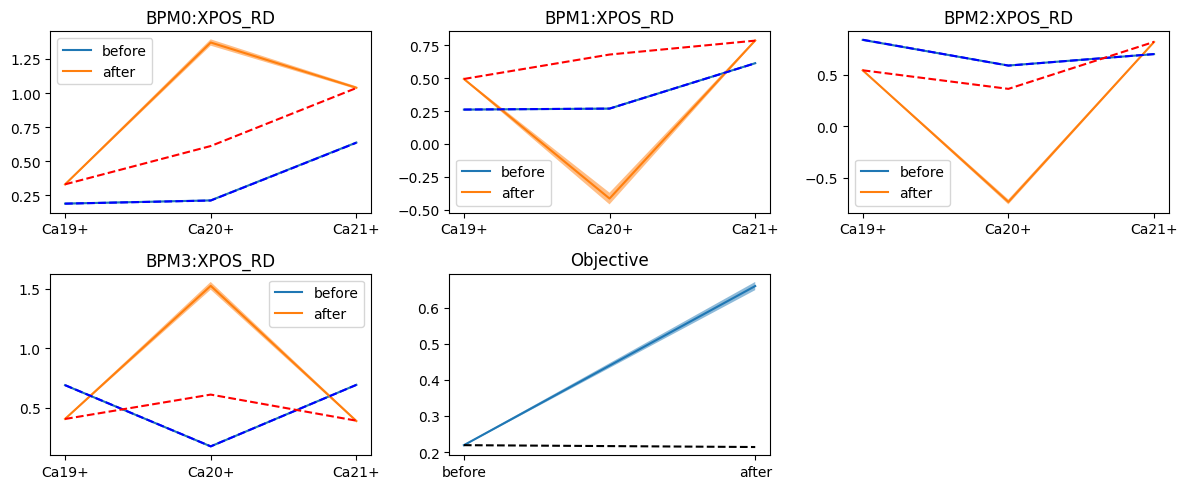

In [11]:
control_values = np.zeros((2,n_control))
control_values[0,:] = msbo.machineIO.history['set_order'][control_CSETs].iloc [0].values
control_values[1,:] = msbo.machineIO.history['set_order'][control_CSETs].iloc[-1].values
fig,ax = plot_msGP_over_states(
    msbo.msGP,
    control_values=control_values,
    control_data_labels = ["before","after"],
    state_names = [f'Ca{19+i}+' for i in range(n_state)],
    objective_PVs = objective_PVs,
    multi_state_objective_fn = multi_state_objective_fn,
    CL = 3,
)

l_ytrue = np.zeros((len(control_values),n_state,n_obj))
l_obj = np.zeros(len(control_values))

for i,x in enumerate(control_values):
    for istate in range(n_state):
        future = msbo.evaluator.submit(x,istate=istate)
        df, df_ramp  = msbo.evaluator.get_result(future)
        y = df[objective_PVs].mean().values
        l_ytrue[i,istate,:] = y
    l_obj[i] = multi_state_objective_fn(torch.tensor(l_ytrue[i,:,:])).item()

for i_obj in range(n_obj):
    ax[i_obj].plot(np.arange(n_state),l_ytrue[0,:,i_obj],'--b')
    ax[i_obj].plot(np.arange(n_state),l_ytrue[1,:,i_obj],'--r')
ax[i_obj+1].plot(np.arange(len(control_values)),l_obj,'--k')

In [12]:
msbo.timecost['fit']

[55.56200000003446,
 54.20299999997951,
 74.625,
 96.78100000001723,
 86.93800000002375,
 101.23399999999674,
 107.96900000004098,
 100.09399999998277,
 108.70299999997951,
 121.64100000000326,
 107.71900000004098]

In [13]:
msbo.timecost['query']

[0.375,
 0.2029999999795109,
 0.39000000001396984,
 0.31299999996554106,
 0.4369999999762513,
 0.34399999998277053,
 0.46899999998277053,
 0.39100000000325963,
 0.23499999998603016,
 0.3119999999762513]